# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
torch.set_float32_matmul_precision('high')
from train import *

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:

def simulate_BM(n_sample, dt, n_timestep):
    noise = torch.randn(size=(n_sample, n_timestep))
    paths_incr = noise * torch.sqrt(torch.tensor(dt))
    paths = torch.cumsum(paths_incr, axis=1)
    BM_paths = torch.cat([torch.zeros((n_sample, 1)), paths], axis=1)
    BM_paths = BM_paths[..., None]
    return BM_paths


def simulate_BS(n_sample, dt, n_timestep, mu, sigma):
    time_grid = torch.linspace(0, dt * n_timestep, n_timestep + 1)
    time_paths = time_grid.expand([n_sample, n_timestep + 1])[..., None]
    BM_paths = simulate_BM(n_sample, dt, n_timestep)
    BS_paths = torch.exp(sigma * BM_paths + (mu - 0.5 * sigma**2) * time_paths)
    return BS_paths


start_date = '1690-01-01'
end_date = '2023-01-01'

t = pd.date_range(start=start_date, end=end_date,freq = 'ME')
n_timestep = len(t)
df = pd.DataFrame({'Date': t, 'spx': t})
df.set_index('Date', inplace=True)
dt = 1/12
mu = 0.1
sigma = 0.2
BS_paths = simulate_BS(1, dt, n_timestep-1, mu, sigma)
path = BS_paths[0,:,0].numpy().astype(np.float64)
df['spx'] = path
df.to_csv('data/bs.csv')
# df.to_csv('data/spx.csv')

# df = pd.read_csv('data/spx.csv', index_col=0, parse_dates=True)
# df.info()
df = pd.read_csv('data/bs.csv', index_col=0, parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3996 entries, 1690-01-31 to 2022-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spx     3996 non-null   float64
dtypes: float64(1)
memory usage: 62.4 KB


In [4]:
# samples
batch_size = 256 # number of samples in each batch
sample_len = 61 # length of each sample
sample_model = 'Realdt' # GBM, Heston, OU, RealData, Realdt, spx_rates
lead_lag = False # whether to use lead lag transformation
lags = [1] # number of lags to use for lead lag transformation: int or list[int]
seed = 42


# BS
batch_size = 64 # number of samples in each batch
sample_len = 61 # length of each sample
stride = 60


In [5]:
# signature kernel
static_kernel_type = 'rq' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels = 5 # number of levels in the truncated signature kernel

# generator
seq_dim = 1 # dimension of sequence vector
activation = 'Tanh' # pytorch names e.g. Tanh, ReLU. NOTE: does NOT change transformer layers'
hidden_size = 64
n_lstm_layers = 1 # number of LSTM layers
conditional = False # feed in history for LSTM generators
hist_len = 11

In [6]:
noise_dim = 1 # dimension of noise vector
ma = True # whether to use MA noise generator fitted to log returns gaussianized by Lambert W transformation
ma_p = 5

### Training Related

In [7]:
epochs = 300 # number of batches
start_lr = 0.001 # starting learning rate
patience = 100 # number of epochs to wait before reducing lr
lr_factor = 0.5 # factor to multiply lr by for scheduler
early_stopping = patience*3 # number of epochs to wait before no improvement
kernel_sigma = 0.2 # starting kernel_sigma
num_losses = 20

### Save to tensorboard log

In [8]:
# save all parameters to a dictionary
rng = np.random.default_rng(seed)
torch.manual_seed(seed)

data_params, model_params, train_params = get_params_dicts(vars().copy())

# save parameters to tensorboard
writer = start_writer(data_params, model_params, train_params)

### Data, kernel, generator

In [9]:
dataloader = get_dataloader(**{**data_params, **model_params, 'bs':True})
kernel = get_signature_kernel(**{**model_params, **train_params})
generator = get_generator(**{**model_params, **data_params})
generator.to(device)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5658.409554271609
            Iterations: 10
            Function evaluations: 83
            Gradient evaluations: 10
                        Zero Mean - ARCH Model Results                        
Dep. Variable:           gaussianized   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5658.41
Distribution:                  Normal   AIC:                           11328.8
Method:            Maximum Likelihood   BIC:                           11366.6
                                        No. Observations:                 3995
Date:                Wed, Sep 04 2024   Df Residuals:                     3995
Time:                        22:07:18   Df Model:                            0
                               Volatility Model                              
  

GenLSTM(
  (rnn): LSTM(3, 64, batch_first=True)
  (mean_net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (var_net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (output_net): Linear(in_features=64, out_features=1, bias=True)
)

# Train MMD-GAN

In [10]:
train(generator, kernel, dataloader, rng, writer, device, **{**train_params, **model_params, **data_params})

/Users/hous/Github/Generative-Model-Signature-MMD/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Epoch 0, loss: 129.5909423828125, avg_last_20_loss: 129.5909423828125
Saving model at epoch 0


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Epoch 1, loss: 109.80126190185547, avg_last_20_loss: 119.69610214233398
Saving model at epoch 1


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Epoch 2, loss: 105.41136169433594, avg_last_20_loss: 114.9345219930013
Saving model at epoch 2


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Epoch 3, loss: 109.70634460449219, avg_last_20_loss: 113.62747764587402
Saving model at epoch 3


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 4, loss: 95.33892822265625, avg_last_20_loss: 109.96976776123047
Saving model at epoch 4


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 5, loss: 98.2368392944336, avg_last_20_loss: 108.01427968343098
Saving model at epoch 5


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Epoch 6, loss: 86.79225158691406, avg_last_20_loss: 104.98256138392857
Saving model at epoch 6


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Epoch 7, loss: 91.97442626953125, avg_last_20_loss: 103.3565444946289
Saving model at epoch 7


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 8, loss: 84.26509857177734, avg_last_20_loss: 101.23527272542317
Saving model at epoch 8


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Epoch 9, loss: 84.0903091430664, avg_last_20_loss: 99.5207763671875
Saving model at epoch 9


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 10, loss: 66.27969360351562, avg_last_20_loss: 96.49885975230823
Saving model at epoch 10


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 11, loss: 49.33182907104492, avg_last_20_loss: 92.56827386220296
Saving model at epoch 11


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 12, loss: 49.859825134277344, avg_last_20_loss: 89.28300857543945
Saving model at epoch 12


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 13, loss: 48.85090637207031, avg_last_20_loss: 86.3950012751988
Saving model at epoch 13


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 14, loss: 53.84516525268555, avg_last_20_loss: 84.22501220703126
Saving model at epoch 14


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 15, loss: 42.73931121826172, avg_last_20_loss: 81.63215589523315
Saving model at epoch 15


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 16, loss: 52.29966735839844, avg_last_20_loss: 79.9067153930664
Saving model at epoch 16


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 17, loss: 43.58720779418945, avg_last_20_loss: 77.88896497090657
Saving model at epoch 17


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 18, loss: 48.07587814331055, avg_last_20_loss: 76.31985513787521
Saving model at epoch 18


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Epoch 19, loss: 35.25293731689453, avg_last_20_loss: 74.26650924682617
Saving model at epoch 19


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 20, loss: 36.870033264160156, avg_last_20_loss: 69.63046379089356
Saving model at epoch 20


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 21, loss: 47.28517150878906, avg_last_20_loss: 66.50465927124023
Saving model at epoch 21


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Epoch 22, loss: 27.769302368164062, avg_last_20_loss: 62.62255630493164
Saving model at epoch 22


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 23, loss: 25.613357543945312, avg_last_20_loss: 58.4179069519043
Saving model at epoch 23


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Epoch 24, loss: 30.884498596191406, avg_last_20_loss: 55.19518547058105
Saving model at epoch 24


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 25, loss: 31.94744110107422, avg_last_20_loss: 51.88071556091309
Saving model at epoch 25


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 26, loss: 26.46734619140625, avg_last_20_loss: 48.86447029113769
Saving model at epoch 26


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 27, loss: 29.441619873046875, avg_last_20_loss: 45.737829971313474
Saving model at epoch 27


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 28, loss: 26.217453002929688, avg_last_20_loss: 42.83544769287109
Saving model at epoch 28


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 29, loss: 32.39800262451172, avg_last_20_loss: 40.25083236694336
Saving model at epoch 29


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 30, loss: 20.657913208007812, avg_last_20_loss: 37.96974334716797
Saving model at epoch 30


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 31, loss: 24.920387268066406, avg_last_20_loss: 36.74917125701904
Saving model at epoch 31


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 32, loss: 16.941001892089844, avg_last_20_loss: 35.10323009490967
Saving model at epoch 32


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 33, loss: 5.020210266113281, avg_last_20_loss: 32.911695289611814
Saving model at epoch 33


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 34, loss: 10.348991394042969, avg_last_20_loss: 30.73688659667969
Saving model at epoch 34


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 35, loss: 9.099853515625, avg_last_20_loss: 29.05491371154785
Saving model at epoch 35


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 36, loss: 12.313644409179688, avg_last_20_loss: 27.055612564086914
Saving model at epoch 36


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 37, loss: 13.182655334472656, avg_last_20_loss: 25.535384941101075
Saving model at epoch 37


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 38, loss: 9.219070434570312, avg_last_20_loss: 23.592544555664062
Saving model at epoch 38


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 39, loss: 8.126632690429688, avg_last_20_loss: 22.23622932434082
Saving model at epoch 39


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Epoch 40, loss: 9.79156494140625, avg_last_20_loss: 20.882305908203126
Saving model at epoch 40


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Epoch 41, loss: 8.482589721679688, avg_last_20_loss: 18.942176818847656
Saving model at epoch 41


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 42, loss: 3.94244384765625, avg_last_20_loss: 17.750833892822264
Saving model at epoch 42


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 43, loss: 9.766891479492188, avg_last_20_loss: 16.95851058959961
Saving model at epoch 43


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 44, loss: 2.795928955078125, avg_last_20_loss: 15.554082107543945
Saving model at epoch 44


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 45, loss: 5.2051239013671875, avg_last_20_loss: 14.216966247558593
Saving model at epoch 45


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 46, loss: 4.6236724853515625, avg_last_20_loss: 13.12478256225586
Saving model at epoch 46


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 47, loss: 3.10382080078125, avg_last_20_loss: 11.807892608642579
Saving model at epoch 47


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 48, loss: 2.414764404296875, avg_last_20_loss: 10.617758178710938
Saving model at epoch 48


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 49, loss: 4.3863067626953125, avg_last_20_loss: 9.217173385620118
Saving model at epoch 49


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 50, loss: 4.6380615234375, avg_last_20_loss: 8.4161808013916
Saving model at epoch 50


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 51, loss: -1.39251708984375, avg_last_20_loss: 7.100535583496094
Saving model at epoch 51


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 52, loss: 0.557037353515625, avg_last_20_loss: 6.2813373565673825
Saving model at epoch 52


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 53, loss: 2.7193145751953125, avg_last_20_loss: 6.166292572021485
Saving model at epoch 53


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 54, loss: -0.095794677734375, avg_last_20_loss: 5.644053268432617
Saving model at epoch 54


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 55, loss: 5.25518798828125, avg_last_20_loss: 5.451819992065429
Saving model at epoch 55


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 56, loss: 0.389068603515625, avg_last_20_loss: 4.855591201782227
Saving model at epoch 56


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 57, loss: -0.4405059814453125, avg_last_20_loss: 4.1744331359863285
Saving model at epoch 57


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 58, loss: 0.3509368896484375, avg_last_20_loss: 3.731026458740234
Saving model at epoch 58


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 59, loss: -0.2965545654296875, avg_last_20_loss: 3.309867095947266
Saving model at epoch 59


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 60, loss: 0.4655303955078125, avg_last_20_loss: 2.8435653686523437
Saving model at epoch 60


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 61, loss: -0.2867584228515625, avg_last_20_loss: 2.4050979614257812
Saving model at epoch 61


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 62, loss: 1.3368988037109375, avg_last_20_loss: 2.2748207092285155
Saving model at epoch 62


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 63, loss: 4.6772613525390625, avg_last_20_loss: 2.0203392028808596
Saving model at epoch 63


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 64, loss: -1.11505126953125, avg_last_20_loss: 1.8247901916503906
Saving model at epoch 64


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 65, loss: 14.447906494140625, avg_last_20_loss: 2.2869293212890627


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 66, loss: 2.286346435546875, avg_last_20_loss: 2.170063018798828


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Epoch 67, loss: 3.7006683349609375, avg_last_20_loss: 2.1999053955078125


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 68, loss: 12.8594970703125, avg_last_20_loss: 2.7221420288085936


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 69, loss: 5.7106475830078125, avg_last_20_loss: 2.7883590698242187


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 70, loss: 3.3744049072265625, avg_last_20_loss: 2.725176239013672


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 71, loss: 12.6773681640625, avg_last_20_loss: 3.4286705017089845


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 72, loss: 4.9529266357421875, avg_last_20_loss: 3.6484649658203123


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 73, loss: -1.1044921875, avg_last_20_loss: 3.457274627685547


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 74, loss: -0.6244354248046875, avg_last_20_loss: 3.4308425903320314


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 75, loss: 9.738143920898438, avg_last_20_loss: 3.654990386962891


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 76, loss: 3.26055908203125, avg_last_20_loss: 3.798564910888672


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 77, loss: 0.0397491455078125, avg_last_20_loss: 3.8225776672363283


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 78, loss: 0.54962158203125, avg_last_20_loss: 3.8325119018554688


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 79, loss: 3.3245391845703125, avg_last_20_loss: 4.013566589355468


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Epoch 80, loss: 1.163055419921875, avg_last_20_loss: 4.048442840576172


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 81, loss: -1.176177978515625, avg_last_20_loss: 4.003971862792969


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 82, loss: -0.261627197265625, avg_last_20_loss: 3.9240455627441406


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 83, loss: 1.2458953857421875, avg_last_20_loss: 3.752477264404297


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 84, loss: -0.48583984375, avg_last_20_loss: 3.7839378356933593


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 85, loss: 0.5588226318359375, avg_last_20_loss: 3.089483642578125


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 86, loss: 1.020721435546875, avg_last_20_loss: 3.026202392578125


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 87, loss: -2.0916900634765625, avg_last_20_loss: 2.73658447265625


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 88, loss: -2.2338104248046875, avg_last_20_loss: 1.9819190979003907


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 89, loss: 2.4380340576171875, avg_last_20_loss: 1.8182884216308595
Saving model at epoch 89


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 90, loss: -1.938720703125, avg_last_20_loss: 1.5526321411132813
Saving model at epoch 90


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 91, loss: -0.680328369140625, avg_last_20_loss: 0.884747314453125
Saving model at epoch 91


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 92, loss: -1.747344970703125, avg_last_20_loss: 0.5497337341308594
Saving model at epoch 92


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 93, loss: 4.1977691650390625, avg_last_20_loss: 0.8148468017578125


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 94, loss: -0.5730438232421875, avg_last_20_loss: 0.8174163818359375


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 95, loss: 4.3144073486328125, avg_last_20_loss: 0.5462295532226562
Saving model at epoch 95


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 96, loss: 4.1655120849609375, avg_last_20_loss: 0.5914772033691407


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 97, loss: 2.5084075927734375, avg_last_20_loss: 0.7149101257324219


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 98, loss: 8.563980102539062, avg_last_20_loss: 1.1156280517578125


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 99, loss: 7.41156005859375, avg_last_20_loss: 1.3199790954589843


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 100, loss: 1.292755126953125, avg_last_20_loss: 1.3264640808105468


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 101, loss: 4.259796142578125, avg_last_20_loss: 1.5982627868652344


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 102, loss: 12.652130126953125, avg_last_20_loss: 2.2439506530761717


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 103, loss: -2.59912109375, avg_last_20_loss: 2.0516998291015627


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 104, loss: -0.698516845703125, avg_last_20_loss: 2.041065979003906


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 105, loss: 0.4467315673828125, avg_last_20_loss: 2.03546142578125


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 106, loss: 0.207733154296875, avg_last_20_loss: 1.99481201171875


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 107, loss: 1.9882659912109375, avg_last_20_loss: 2.198809814453125


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 108, loss: 0.89776611328125, avg_last_20_loss: 2.355388641357422


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 109, loss: 1.55096435546875, avg_last_20_loss: 2.31103515625


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 110, loss: -3.1557769775390625, avg_last_20_loss: 2.250182342529297


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 111, loss: -0.2667694091796875, avg_last_20_loss: 2.270860290527344


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 112, loss: 0.7168121337890625, avg_last_20_loss: 2.394068145751953


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 113, loss: -0.004241943359375, avg_last_20_loss: 2.1839675903320312


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 114, loss: -1.064605712890625, avg_last_20_loss: 2.1593894958496094


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 115, loss: -1.262603759765625, avg_last_20_loss: 1.8805389404296875


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 116, loss: 2.698638916015625, avg_last_20_loss: 1.807195281982422


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 117, loss: 3.066375732421875, avg_last_20_loss: 1.8350936889648437


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 118, loss: -4.5921173095703125, avg_last_20_loss: 1.177288818359375


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 119, loss: 0.290863037109375, avg_last_20_loss: 0.8212539672851562


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 120, loss: 1.81549072265625, avg_last_20_loss: 0.8473907470703125


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 121, loss: 6.001068115234375, avg_last_20_loss: 0.934454345703125


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 122, loss: 2.882720947265625, avg_last_20_loss: 0.44598388671875
Saving model at epoch 122


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 123, loss: -1.023895263671875, avg_last_20_loss: 0.5247451782226562


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 124, loss: -0.1625823974609375, avg_last_20_loss: 0.5515419006347656


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 125, loss: 0.5641021728515625, avg_last_20_loss: 0.5574104309082031


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 126, loss: 0.433685302734375, avg_last_20_loss: 0.5687080383300781


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 127, loss: 1.510467529296875, avg_last_20_loss: 0.544818115234375


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 128, loss: -2.681365966796875, avg_last_20_loss: 0.36586151123046873
Saving model at epoch 128


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 129, loss: -1.82025146484375, avg_last_20_loss: 0.19730072021484374
Saving model at epoch 129


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 130, loss: 7.227630615234375, avg_last_20_loss: 0.7164710998535156


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 131, loss: -2.2930908203125, avg_last_20_loss: 0.615155029296875


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 132, loss: -1.0438995361328125, avg_last_20_loss: 0.5271194458007813


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 133, loss: 0.6963043212890625, avg_last_20_loss: 0.5621467590332031


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 134, loss: 7.12457275390625, avg_last_20_loss: 0.9716056823730469


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 135, loss: -0.004608154296875, avg_last_20_loss: 1.0345054626464845


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 136, loss: -0.315185546875, avg_last_20_loss: 0.8838142395019531


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 137, loss: 4.823822021484375, avg_last_20_loss: 0.9716865539550781


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 138, loss: 1.884063720703125, avg_last_20_loss: 1.29549560546875


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 139, loss: 0.113739013671875, avg_last_20_loss: 1.286639404296875


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 140, loss: 5.939361572265625, avg_last_20_loss: 1.4928329467773438


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 141, loss: 1.7876129150390625, avg_last_20_loss: 1.282160186767578


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 142, loss: 8.3846435546875, avg_last_20_loss: 1.557256317138672


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 143, loss: -0.407257080078125, avg_last_20_loss: 1.5880882263183593


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 144, loss: 5.7513275146484375, avg_last_20_loss: 1.883783721923828


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 145, loss: 1.7915496826171875, avg_last_20_loss: 1.9451560974121094


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 146, loss: 0.4270782470703125, avg_last_20_loss: 1.9448257446289063


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 147, loss: -2.778839111328125, avg_last_20_loss: 1.7303604125976562


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 148, loss: 4.884185791015625, avg_last_20_loss: 2.1086380004882814


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 149, loss: 0.3388214111328125, avg_last_20_loss: 2.216591644287109


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 150, loss: 3.7724761962890625, avg_last_20_loss: 2.043833923339844


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 151, loss: -1.8925018310546875, avg_last_20_loss: 2.0638633728027345


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Epoch 152, loss: 8.035980224609375, avg_last_20_loss: 2.5178573608398436


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 153, loss: 6.612640380859375, avg_last_20_loss: 2.8136741638183596


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 154, loss: 1.0386962890625, avg_last_20_loss: 2.509380340576172


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 155, loss: -1.0382537841796875, avg_last_20_loss: 2.4576980590820314


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Epoch 156, loss: 0.9170379638671875, avg_last_20_loss: 2.519309234619141


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 157, loss: 4.4580841064453125, avg_last_20_loss: 2.5010223388671875


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 158, loss: 0.088226318359375, avg_last_20_loss: 2.41123046875


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 159, loss: 2.285552978515625, avg_last_20_loss: 2.5198211669921875


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 160, loss: 0.2617034912109375, avg_last_20_loss: 2.2359382629394533


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 161, loss: 1.178955078125, avg_last_20_loss: 2.20550537109375


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 162, loss: 2.099365234375, avg_last_20_loss: 1.891241455078125


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Epoch 163, loss: -0.500885009765625, avg_last_20_loss: 1.88656005859375


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 164, loss: -1.42657470703125, avg_last_20_loss: 1.5276649475097657


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 165, loss: 0.4769287109375, avg_last_20_loss: 1.4619338989257813


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 166, loss: 4.43414306640625, avg_last_20_loss: 1.662287139892578


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 167, loss: -1.602935791015625, avg_last_20_loss: 1.7210823059082032


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Epoch 168, loss: -0.234283447265625, avg_last_20_loss: 1.4651588439941405


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Epoch 169, loss: -0.9024200439453125, avg_last_20_loss: 1.4030967712402345


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 170, loss: 1.8156280517578125, avg_last_20_loss: 1.3052543640136718


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Epoch 171, loss: -2.9757537841796875, avg_last_20_loss: 1.251091766357422


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 172, loss: 2.6272125244140625, avg_last_20_loss: 0.9806533813476562


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 173, loss: 2.42596435546875, avg_last_20_loss: 0.771319580078125


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 174, loss: 0.696136474609375, avg_last_20_loss: 0.7541915893554687


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 175, loss: 5.15802001953125, avg_last_20_loss: 1.0640052795410155


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 176, loss: 2.317962646484375, avg_last_20_loss: 1.134051513671875


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 177, loss: 1.6418609619140625, avg_last_20_loss: 0.9932403564453125


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 178, loss: -2.9840240478515625, avg_last_20_loss: 0.8396278381347656


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Epoch 179, loss: -0.653594970703125, avg_last_20_loss: 0.6926704406738281


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 180, loss: -0.8168182373046875, avg_last_20_loss: 0.6387443542480469


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Epoch 181, loss: 0.772857666015625, avg_last_20_loss: 0.6184394836425782


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 182, loss: -2.1260528564453125, avg_last_20_loss: 0.4071685791015625


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 183, loss: -1.6659393310546875, avg_last_20_loss: 0.34891586303710936


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 184, loss: 2.2216033935546875, avg_last_20_loss: 0.5313247680664063


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 185, loss: 2.4814453125, avg_last_20_loss: 0.6315505981445313


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Epoch 186, loss: -0.425689697265625, avg_last_20_loss: 0.3885589599609375


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 187, loss: 2.738250732421875, avg_last_20_loss: 0.6056182861328125


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 188, loss: 3.735015869140625, avg_last_20_loss: 0.804083251953125


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Epoch 189, loss: -0.5580291748046875, avg_last_20_loss: 0.8213027954101563


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 190, loss: -3.3905792236328125, avg_last_20_loss: 0.560992431640625


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 191, loss: 4.4688568115234375, avg_last_20_loss: 0.9332229614257812


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Epoch 192, loss: -0.2370147705078125, avg_last_20_loss: 0.7900115966796875


100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Epoch 193, loss: -2.407867431640625, avg_last_20_loss: 0.5483200073242187


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Epoch 194, loss: 1.4824371337890625, avg_last_20_loss: 0.5876350402832031


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 195, loss: 0.971343994140625, avg_last_20_loss: 0.37830123901367185


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 196, loss: -0.53570556640625, avg_last_20_loss: 0.23561782836914064


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 197, loss: 2.9091949462890625, avg_last_20_loss: 0.2989845275878906


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 198, loss: -1.2646484375, avg_last_20_loss: 0.38495330810546874


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 199, loss: 1.327911376953125, avg_last_20_loss: 0.48402862548828124


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 200, loss: -2.7594451904296875, avg_last_20_loss: 0.38689727783203126


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 201, loss: -2.1790771484375, avg_last_20_loss: 0.239300537109375


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 202, loss: 0.816558837890625, avg_last_20_loss: 0.3864311218261719


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 203, loss: -1.071807861328125, avg_last_20_loss: 0.4161376953125


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 204, loss: 2.023223876953125, avg_last_20_loss: 0.4062187194824219


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 205, loss: -0.7462158203125, avg_last_20_loss: 0.24483566284179686


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 206, loss: 1.18731689453125, avg_last_20_loss: 0.3254859924316406


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 207, loss: 6.24432373046875, avg_last_20_loss: 0.5007896423339844


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 208, loss: 0.9226226806640625, avg_last_20_loss: 0.36016998291015623


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Epoch 209, loss: -1.30615234375, avg_last_20_loss: 0.32276382446289065


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 210, loss: -0.135955810546875, avg_last_20_loss: 0.4854949951171875


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 211, loss: -1.95782470703125, avg_last_20_loss: 0.16416091918945314
Saving model at epoch 211


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 212, loss: -0.4862060546875, avg_last_20_loss: 0.15170135498046874
Saving model at epoch 212


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 213, loss: 3.2785797119140625, avg_last_20_loss: 0.4360237121582031


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 214, loss: 0.3123779296875, avg_last_20_loss: 0.377520751953125


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Epoch 215, loss: -2.316070556640625, avg_last_20_loss: 0.2131500244140625


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 216, loss: 2.4332427978515625, avg_last_20_loss: 0.36159744262695315


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 217, loss: 1.3295135498046875, avg_last_20_loss: 0.28261337280273435


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 218, loss: -0.8982391357421875, avg_last_20_loss: 0.300933837890625


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 219, loss: 1.1839141845703125, avg_last_20_loss: 0.2937339782714844


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 220, loss: 1.458282470703125, avg_last_20_loss: 0.504620361328125


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 221, loss: 9.412750244140625, avg_last_20_loss: 1.0842117309570312


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 222, loss: 3.4751129150390625, avg_last_20_loss: 1.217139434814453


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Epoch 223, loss: -3.92547607421875, avg_last_20_loss: 1.074456024169922


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 224, loss: 4.6055145263671875, avg_last_20_loss: 1.203570556640625


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 225, loss: -1.2724609375, avg_last_20_loss: 1.17725830078125


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 226, loss: 0.3819122314453125, avg_last_20_loss: 1.136988067626953


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 227, loss: -2.2081298828125, avg_last_20_loss: 0.7143653869628906


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 228, loss: 0.7589111328125, avg_last_20_loss: 0.7061798095703125


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 229, loss: -0.3425750732421875, avg_last_20_loss: 0.7543586730957031


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 230, loss: -1.4158172607421875, avg_last_20_loss: 0.6903656005859375


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 231, loss: -3.3927764892578125, avg_last_20_loss: 0.6186180114746094


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 232, loss: 0.121551513671875, avg_last_20_loss: 0.6490058898925781


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 233, loss: -2.2520904541015625, avg_last_20_loss: 0.37247238159179685


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 234, loss: -1.3719940185546875, avg_last_20_loss: 0.2882537841796875


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Epoch 235, loss: -3.0714874267578125, avg_last_20_loss: 0.25048294067382815


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 236, loss: 4.24786376953125, avg_last_20_loss: 0.3412139892578125


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Epoch 237, loss: 7.9027252197265625, avg_last_20_loss: 0.6698745727539063


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 238, loss: 0.6985321044921875, avg_last_20_loss: 0.749713134765625


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 239, loss: -1.127532958984375, avg_last_20_loss: 0.6341407775878907


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Epoch 240, loss: 4.734954833984375, avg_last_20_loss: 0.7979743957519532


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 241, loss: 3.989959716796875, avg_last_20_loss: 0.5268348693847656


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 242, loss: -0.6647186279296875, avg_last_20_loss: 0.3198432922363281


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 243, loss: 8.47259521484375, avg_last_20_loss: 0.9397468566894531


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 244, loss: 6.1179656982421875, avg_last_20_loss: 1.0153694152832031


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 245, loss: -3.217437744140625, avg_last_20_loss: 0.9181205749511718


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 246, loss: 1.15447998046875, avg_last_20_loss: 0.9567489624023438


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 247, loss: -0.1963958740234375, avg_last_20_loss: 1.057335662841797


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Epoch 248, loss: -0.2133636474609375, avg_last_20_loss: 1.008721923828125


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 249, loss: 2.737335205078125, avg_last_20_loss: 1.1627174377441407


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 250, loss: -2.3350372314453125, avg_last_20_loss: 1.1167564392089844


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 251, loss: 2.2827301025390625, avg_last_20_loss: 1.4005317687988281


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 252, loss: -1.6043853759765625, avg_last_20_loss: 1.3142349243164062


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 253, loss: -1.960174560546875, avg_last_20_loss: 1.3288307189941406


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 254, loss: -2.69622802734375, avg_last_20_loss: 1.2626190185546875


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 255, loss: -1.47491455078125, avg_last_20_loss: 1.3424476623535155


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 256, loss: -1.379425048828125, avg_last_20_loss: 1.0610832214355468


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 257, loss: -3.1935272216796875, avg_last_20_loss: 0.5062705993652343


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 258, loss: -1.565704345703125, avg_last_20_loss: 0.39305877685546875


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 259, loss: 2.4511566162109375, avg_last_20_loss: 0.5719932556152344


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 260, loss: -2.6476898193359375, avg_last_20_loss: 0.20286102294921876


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 261, loss: -1.2123565673828125, avg_last_20_loss: -0.057254791259765625
Saving model at epoch 261


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 262, loss: -2.2839813232421875, avg_last_20_loss: -0.13821792602539062
Saving model at epoch 262


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 263, loss: 5.6474761962890625, avg_last_20_loss: -0.279473876953125
Saving model at epoch 263


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 264, loss: 1.31488037109375, avg_last_20_loss: -0.5196281433105469
Saving model at epoch 264


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 265, loss: 11.315841674804688, avg_last_20_loss: 0.20703582763671874


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 266, loss: -0.295379638671875, avg_last_20_loss: 0.1345428466796875


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 267, loss: -1.7006378173828125, avg_last_20_loss: 0.05933074951171875


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 268, loss: -1.9019775390625, avg_last_20_loss: -0.025099945068359376


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 269, loss: -0.9242401123046875, avg_last_20_loss: -0.2081787109375


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 270, loss: -1.0998687744140625, avg_last_20_loss: -0.1464202880859375


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 271, loss: -1.7608184814453125, avg_last_20_loss: -0.34859771728515626


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 272, loss: -0.998748779296875, avg_last_20_loss: -0.3183158874511719


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 273, loss: -0.504638671875, avg_last_20_loss: -0.24553909301757812


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 274, loss: -0.2505950927734375, avg_last_20_loss: -0.1232574462890625


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Epoch 275, loss: 0.2513275146484375, avg_last_20_loss: -0.036945343017578125


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 276, loss: -1.2770538330078125, avg_last_20_loss: -0.0318267822265625


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Epoch 277, loss: 0.63104248046875, avg_last_20_loss: 0.15940170288085936


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 278, loss: -0.422210693359375, avg_last_20_loss: 0.21657638549804686


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 279, loss: -1.166473388671875, avg_last_20_loss: 0.03569488525390625


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 280, loss: -1.7915802001953125, avg_last_20_loss: 0.0785003662109375


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Epoch 281, loss: -0.16192626953125, avg_last_20_loss: 0.13102188110351562


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 282, loss: -2.4035491943359375, avg_last_20_loss: 0.12504348754882813


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 283, loss: 0.2404632568359375, avg_last_20_loss: -0.14530715942382813


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 284, loss: -0.402069091796875, avg_last_20_loss: -0.23115463256835939


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 285, loss: -2.48797607421875, avg_last_20_loss: -0.9213455200195313
Saving model at epoch 285


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 286, loss: -2.5111541748046875, avg_last_20_loss: -1.0321342468261718
Saving model at epoch 286


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 287, loss: 15.4217529296875, avg_last_20_loss: -0.17601470947265624


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Epoch 288, loss: 0.7322540283203125, avg_last_20_loss: -0.04430313110351562


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Epoch 289, loss: -3.918212890625, avg_last_20_loss: -0.19400177001953126


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Epoch 290, loss: 7.6304779052734375, avg_last_20_loss: 0.24251556396484375


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 291, loss: 5.807952880859375, avg_last_20_loss: 0.6209541320800781


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 292, loss: -2.3037872314453125, avg_last_20_loss: 0.5557022094726562


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Epoch 293, loss: -3.4062652587890625, avg_last_20_loss: 0.41062088012695314


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 294, loss: 3.3850860595703125, avg_last_20_loss: 0.5924049377441406


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Epoch 295, loss: 8.854782104492188, avg_last_20_loss: 1.022577667236328


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Epoch 296, loss: -2.70556640625, avg_last_20_loss: 0.9511520385742187


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Epoch 297, loss: -0.3976593017578125, avg_last_20_loss: 0.8997169494628906


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Epoch 298, loss: -0.6368560791015625, avg_last_20_loss: 0.8889846801757812


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]

Epoch 299, loss: -0.7463531494140625, avg_last_20_loss: 0.9099906921386719


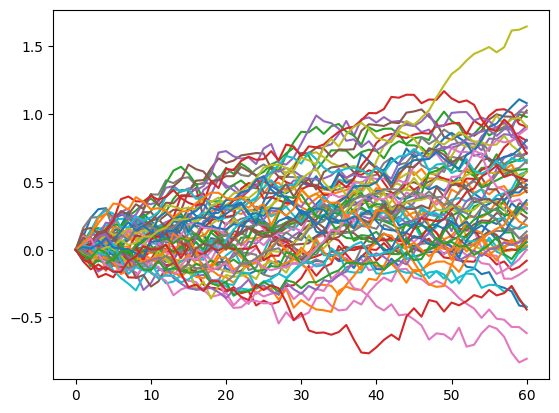

66
torch.Size([64, 61, 2])
torch.Size([64, 60, 1])


In [11]:
# Visualize data
for item in dataloader:
    plt.plot(item[0][:,:,1].T)
plt.show()
print(len(dataloader.dataset))
print(item[0].shape)
print(item[1].shape)

In [12]:
path = item[0]
n_noise = 500

t_single = path[:1,:,:1]
t = torch.tile(t_single, [n_noise,1,1])

self = dataloader.dataset

ma_model = arch.arch_model(self.df['spx'], mean=MEAN_MODEL, p=self.p, q=Q_CONST, rescale=False)
ma_model.distribution = Normal(seed=self.rs)
forecasts = ma_model.forecast(params=self.res.params, horizon=self.sample_len-1, method='simulation', simulations=n_noise)
noise = forecasts.simulations.residuals[0].T
noise = torch.tensor(noise, dtype=path.dtype, requires_grad=False)
noise = torch.swapaxes(noise, 0, 1).unsqueeze(2)

print(noise.shape, t.shape)
with torch.no_grad():
    output = generator(noise, t)
    output = torch.cat([t, output], axis=-1) # concatenate time and generated path along time series value dimension

torch.Size([500, 60, 1]) torch.Size([500, 61, 1])


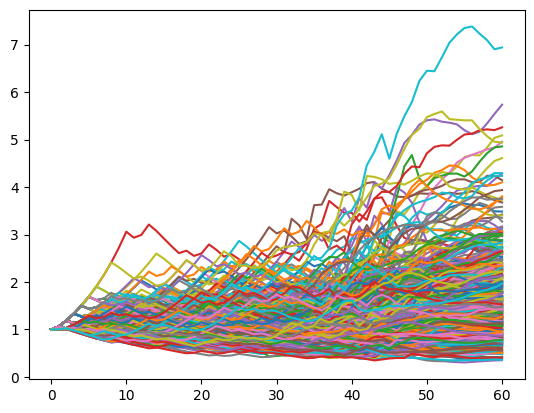

In [13]:
plt.plot(output[:,:,1].exp().T);